In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install accelerate
!pip install datasets
!pip install shap


In [3]:
!pip install Optuna


In [4]:

!pip install textstat
!pip install pyspellchecker





In [5]:
from collections import Counter
import textstat
from spellchecker import SpellChecker
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from huggingface_hub import HfFolder, Repository
from sklearn.metrics import cohen_kappa_score
from datasets import Dataset, get_dataset_config_names
import polars as pl
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
import numpy as np
from transformers import (AutoTokenizer,
                          TrainingArguments,
                          DataCollatorWithPadding,
                          Trainer,
                          AutoModelForSequenceClassification,
                           EarlyStoppingCallback
                          )
import regex as re
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from google.colab import userdata
import ctypes, torch, gc, yaml,  joblib, spacy, multiprocessing, os, random, functools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import lightgbm as lgb
import shap
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin

In [6]:
key_ = userdata.get('HF_TOKEN')
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_path = '/content/drive/MyDrive/essay/data/train.csv'
libc = ctypes.CDLL("libc.so.6")

cuda


In [7]:
args_no = 0
args = f'/content/drive/MyDrive/essay/args/args_{args_no}.yaml'

with open(args, 'r') as file:
  config = yaml.safe_load(file)


In [8]:

def clear_memory():
    libc.malloc_trim(0)
    torch.cuda.empty_cache()
    gc.collect()



In [9]:
lbl_mapping = { j: i for i, j in enumerate(config['lbl'])}


df_full = (pl.scan_csv(train_path)
        .with_columns(
            score = pl.col('score')
            .replace(lbl_mapping)
        )
      )


In [10]:
def initialize_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

initialize_seeds(config['seed'])

In [11]:


class text_prep():
  def __init__(self,
               df,
               tokenizer,
               max_length = config['max_length'],
               batch_size = config['batch_size'],
               stride = config['stride']
               ):

    self.set_df(df)
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.batch_size  = batch_size
    self.stride = stride

  def tokenize_function(self, batch):
    try:
        input_ids = []
        essay_id = []
        attention_mask = []
        full_text = []
        score = []
        txts = [self.preprocess_text(i) for i in batch['full_text']]

        for count_id , txt in enumerate(txts):
          tokenized = self.tokenizer(txt,
                                    max_length=self.max_length,
                                    return_overflowing_tokens = True,
                                    stride = self.stride,
                                    truncation=True
                                    )


          for count, input in enumerate(tokenized['input_ids']):
            full_text.append(txt)
            score.append(batch['score'][count_id])
            essay_id.append(batch['essay_id'][count_id])
            input_ids.append(input)
            attention_mask.append(tokenized['attention_mask'][count])

        return {
            'essay_id': essay_id,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'full_text': full_text,
            'score': score
        }
    except Exception as e:
        print(f"Error tokenizing batch: {batch}")
        raise e

  def preprocess_text(self, text):
    text = text.replace('\xa0', ' ')
    text = re.sub(r"[^a-zA-Z0-9\s,.'!?;:-]", '', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

  def set_df(self, val):
    if isinstance(val, Dataset):
      self.df = val
    elif isinstance(val, pl.DataFrame):
      arrow_table = val.to_arrow()
      self.df = Dataset(arrow_table)
    else:
      raise TypeError("Unsupported data")



  def fit_transform(self):
     return (self.df.map(self.tokenize_function,
                         num_proc=multiprocessing.cpu_count() -1,
                         batched = True
                         )
                    .rename_column('score', 'labels')
     )


In [12]:
# change here
def token_df(tokenizer, df_full):
  df_sample = df_full.collect()
  tp = text_prep(df_sample, tokenizer = tokenizer)
  return tp.fit_transform()


In [13]:

def class_report(pred_df, fold):
  return (pd.DataFrame(classification_report(pred_df["labels"],
                                      pred_df["new_lbl"],
                                      output_dict = True))
  .T
  .iloc[0:6]
  .rename(
      columns = {'f1-score': f'fold_{fold}_f1'}
  )
  .loc[:, f'fold_{fold}_f1']
  )


In [14]:

def confusion(scoring):
  labels = sorted(scoring[:, 'labels'].unique().to_list())


  cm = confusion_matrix(scoring[:, "labels"].to_list(),
                        scoring[:, "new_lbl"].to_list(),
                        labels=labels,
                        )
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  ax = disp.ax_
  plt.xticks(range(len(labels)), labels, rotation=90, ha='right')
  plt.subplots_adjust(bottom=0.2)
  plt.show()


In [15]:
class PredictionProcess:
    def __init__(self, best_model, pad_to_multiple_of, device, batch_size, tokenizer):
        self.model = AutoModelForSequenceClassification.from_pretrained(best_model).to(device)
        self.data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=pad_to_multiple_of)
        self.batch_size = batch_size
        self.device = device


    @staticmethod
    def predict(batch, model, data_collator, device):
        collated_batch = data_collator({k: batch[k]
                                for k in batch
                                if k in ['input_ids', 'attention_mask']}
                              )

        input_ids = collated_batch['input_ids'].to(device)
        attention_mask = collated_batch['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        pred_labels = outputs.logits.argmax(dim=-1).cpu().tolist()
        return {'pred_labels': pred_labels, 'logits': outputs.logits.cpu().tolist()}


    def _most_common(self, lst):
        counts = Counter(lst)
        max_frequency = max(counts.values())
        return [e for e, c in counts.items() if c == max_frequency]


    def _vote_pred(self, r):
      lbl_agg = r['lbl_agg']
      max_value_agg = r['max_value_agg']

      if len(lbl_agg) > 1:
        mc = self._most_common(lbl_agg)
        val_dic = {}
        data = list(zip(lbl_agg, max_value_agg))

        if len(mc) > 1:
          for i in mc:
            val_dic[i] = max(val for lbl, val in data if i == lbl)
        else:
          val_dic[mc[0]] = max(val for lbl, val in data if mc[0] == lbl)

        max_lbl = max(val_dic, key=val_dic.get)
        return {'new_lbl': max_lbl, 'val': val_dic[max_lbl]}
      else:
        return {'new_lbl': lbl_agg[0], 'val': max_value_agg[0]}




    def predict_dataset(self, dataset):
        self.model.eval()
        predict_partial = functools.partial(self.predict,
                                  model=self.model,
                                  data_collator=self.data_collator,
                                  device=self.device
                                  )
        pred = dataset.map(
            predict_partial,
            batched=True,
            batch_size=self.batch_size,
            remove_columns=['input_ids', 'attention_mask']
        )

        clear_memory()

        return (pred
                .to_polars()
                .unique(subset = 'essay_id')
               )





In [16]:
class CustomLGBMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 lgbm_params,
                 model_path,
                 config,
                 tokenizer,
                 df_txt,
                 device= device):

        self.lgbm_params = lgbm_params
        self.model_path = model_path
        self.config = config
        self.tokenizer = tokenizer
        self.device = device
        self.df_txt = df_txt

    def _merge_txt(self, df_txt, pred_df):
        return (df_txt.drop(['labels', 'input_ids', 'attention_mask']).join(
            pred_df.with_columns(
                lbl_temp=pl.struct('logits').map_elements(lambda f: {f'lbl_{i}': j for i, j in enumerate(f['logits'])})
            ).unnest(['lbl_temp']).drop(['pred_labels', 'logits', 'full_text']),
            on='essay_id'
        ))

    def _transformer_prediction(self, X):
        predict = PredictionProcess(
            best_model=self.model_path,
            pad_to_multiple_of=self.config['pad_to_multiple_of'],
            device=self.device,
            batch_size=self.config['batch_size'],
            tokenizer=self.tokenizer
        )
        return self._merge_txt(self.df_txt, predict.predict_dataset(X))

    @staticmethod
    def _qwk(y_true, y_pred):
        y_pred = np.clip(np.round(y_pred), 0, config['split']).astype(int)
        return 'qwk', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True




    def fit(self, X, y, X_val=None, y_val=None):
        self.early_stopping_callback = lgb.early_stopping(stopping_rounds=self.config['stopping_rounds'])
        self.scaler = MinMaxScaler()


        X_ = self._transformer_prediction(X)
        X_  = X_.drop(['essay_id', 'labels']).to_pandas()

        X_val_ = self._transformer_prediction(X_val)
        X_val_  = X_val_.drop(['essay_id', 'labels']).to_pandas()


        self.scaler.fit(X_)

        X_ = self.scaler.transform(X_)
        X_val_ = self.scaler.transform(X_val_)

        self.model_lgbm = lgb.LGBMRegressor(**self.lgbm_params)
        self.model_lgbm.fit(
            X_,
            y,
            eval_set=[(X_, y), (X_val_, y_val)],
            eval_metric=self._qwk,
            callbacks=[self.early_stopping_callback]
        )

    def predict(self, X):
        X_ = X
        X_ = self._transformer_prediction(X_)

        if 'essay_id' in X_.columns:
          X_ = X_.drop('essay_id')

        if 'labels' in X_.columns:
          X_ = X_.drop('labels')

        X_ = X_.to_pandas()


        X_ = self.scaler.transform(X_)
        return self.model_lgbm.predict(X_)


In [17]:

spell = SpellChecker()

def get_misspelled_words(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(list(misspelled))

def calculate_readability_and_spelling(text):
    flesch_kincaid = textstat.flesch_kincaid_grade(text)
    gunning_fog = textstat.gunning_fog(text)
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    difficult_words_count = textstat.difficult_words(text)
    sentence_count = textstat.sentence_count(text)
    alpine_score = textstat.mcalpine_eflaw(text)
    word_count = len(text.split())
    avg_sentence_length = word_count / sentence_count if sentence_count else 0
    misspelled_words = get_misspelled_words(text)
    read_time = textstat.reading_time(text)

    return {
        "flesch_kincaid": flesch_kincaid,
        "gunning_fog": gunning_fog,
        "flesch_reading_ease": flesch_reading_ease,
        "difficult_words_count": difficult_words_count,
        "sentence_count": sentence_count,
        "alpine_score": alpine_score,
        "avg_sentence_length": avg_sentence_length,
        "misspelled_words": misspelled_words,
        "read_time": read_time
    }


def merge_txt(df_txt, pred_df):
    return (df_txt.drop(['labels','input_ids',	'attention_mask']).join(
        (pred_df
        .with_columns(
            lbl_temp = pl.struct('logits')
            .map_elements(lambda f:{f'lbl_{i}':j for i, j in enumerate(f['logits'])} )
        )
        .unnest(['lbl_temp'])
        .drop(['pred_labels', 'logits', 'full_text'])

        )
        ,on = 'essay_id'
        )
    )

In [18]:


essay_id = list(set(df_full.collect()['essay_id']))

df_pd = (
        df_full
        .filter(pl.col('essay_id').is_in(essay_id))
        .collect()
        .to_pandas()
       )


In [19]:
early_stopping_callback = lgb.early_stopping(stopping_rounds=config['stopping_rounds'])

df_dic = {}
model_dic_score={}
shap_dic = {}
stratified_kfold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(df_pd, df_pd['score'])):

    print(f'fold number: {fold}')
    model_path = f"{config['best_model']}{args_no}_{config['base_model']}_{fold}"
    if fold == 0:
      tokenizer = AutoTokenizer.from_pretrained(model_path)
      df = token_df(tokenizer, df_full)

      df_txt = (df
           .to_polars()
            .with_columns(
                txt_meta = pl.col('full_text')
                .map_elements(calculate_readability_and_spelling)
            )
            .unnest(['txt_meta'])
            .drop([ 'full_text'])
      )




    train_index, val_index = train_test_split(train_index, test_size=0.2, random_state=config['seed'])

    x_train_ =  df.filter(lambda f: f['essay_id'] in df_pd.iloc[train_index].loc[:, 'essay_id'].to_list())
    x_vali_ =  df.filter(lambda f: f['essay_id'] in df_pd.iloc[val_index].loc[:, 'essay_id'].to_list())
    x_test_ = df.filter(lambda f: f['essay_id'] in df_pd.iloc[test_index].loc[:, 'essay_id'].to_list())



    y_train = np.array(x_train_['labels'])
    y_vali = np.array(x_vali_['labels'])
    y_test  = np.array(x_test_['labels'])


    model_reg = CustomLGBMRegressor(
            lgbm_params = config['params'],
            model_path = model_path,
            config = config,
            tokenizer = tokenizer,
            df_txt = df_txt,
    )

    model_reg.fit(x_train_, y_train, x_vali_, y_vali)
    y_pred = model_reg.predict(x_test_)
    y_pred =  np.clip(np.round(y_pred), 0, config['split']).astype(int)
    qwk_score_lgbtm = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    print(f'{fold}:qwk_score_lgbtm:  {qwk_score_lgbtm }')
    clear_memory()
    break


fold number: 0


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map:   0%|          | 0/11076 [00:00<?, ? examples/s]

Map:   0%|          | 0/2769 [00:00<?, ? examples/s]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 11076, number of used features: 15
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Start training from score 1.955670
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's l2: 0.119563	training's qwk: 0.939959	valid_1's l2: 0.367582	valid_1's qwk: 0.785414


Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
0:qwk_score_lgbtm:  0.7903310688431093


In [24]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [73]:

h = np.round(np.array([1.2, 3.67]))


np.array(list(map(int, np.round(c))))




array([1, 4])

In [ ]:
shap_values = shap_dic[fold]['shap']
test = shap_dic[fold]['test']
train = shap_dic[fold]['train']
assert shap_values.shape[1] == x_test.shape[1]



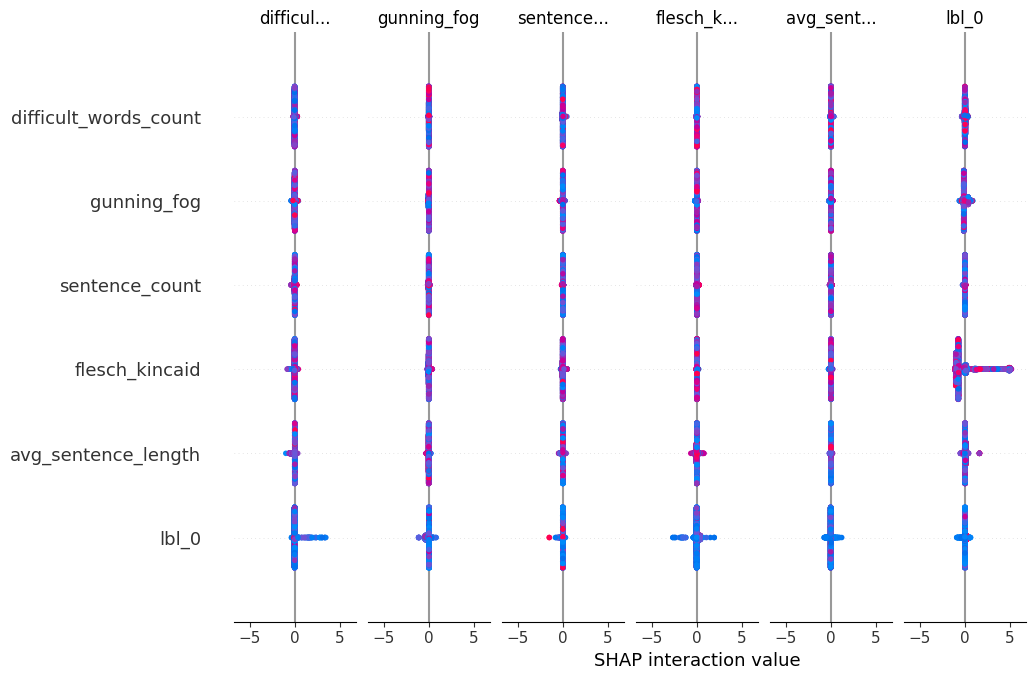

<Figure size 640x480 with 0 Axes>

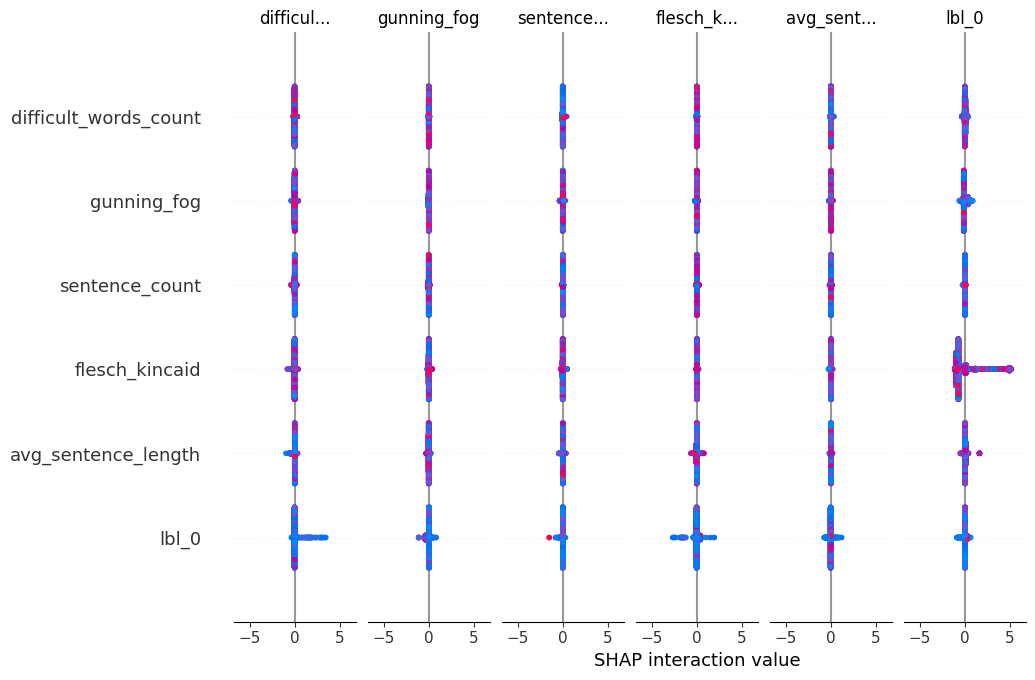

In [ ]:
num_features = features
shap_plot_summary = f"{config['args_path']}/shap_summary_plot_fold_{fold}.png"
shap_plot_bar = f"{config['args_path']}/shap_bar_plot_fold_{fold}.png"
shap.summary_plot(shap_values, x_test,  feature_names=num_features, show=True)
plt.savefig(shap_plot_summary)
shap.summary_plot(shap_values, x_test, plot_type="bar",  feature_names=num_features, show=False)
plt.savefig(shap_plot_bar)

In [ ]:
(pd.DataFrame(model_dic_score)
.assign(
    avg = lambda f: f.apply(lambda g: np.mean(g), axis = 1)
)
)

,0,1,2,3,4,avg
qwk_score_lgbtm,0.797580,0.808168,0.796136,0.794107,0.793564,0.797911
qwk_score_trans,0.797391,0.776613,0.771725,0.793133,0.791270,0.786026
